In [1]:
import numpy as np
import os
import sys

import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torch import nn, Tensor

from functools import partial
from tqdm.notebook import tqdm
from typing import Callable, Dict, Iterable, List, Tuple

In [2]:
import cv2
import PIL

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
BASE_DIR = '/home/dmitry/projects/dfdc'
SRC_DIR = os.path.join(BASE_DIR, 'src')
HDF5_DIR = '/media/dmitry/other/dfdc-crops/hdf5'
IMG_DIR = '/media/dmitry/other/dfdc-crops/webp_lossy'

In [5]:
sys.path.insert(0, SRC_DIR)
sys.path.insert(0, './utils')

In [6]:
from dataset import HDF5Dataset, ImagesDataset, FrameSampler, BalancedSampler
from visualise import show_images

In [7]:
from torch.utils.data import DataLoader, BatchSampler

In [8]:
def create_loader(conf: Dict, transforms: Iterable[Callable],
                  dirs: Iterable[str]) -> DataLoader:
    num_frames = conf['frames']
    
    sampler = FrameSampler(num_frames, 
                           real_fake_ratio=conf['real_fake_ratio'],
                           p_sparse=conf['p_sparse'])
    
    ds = HDF5Dataset(HDF5_DIR,
                     frames=num_frames,
                     sampler=sampler,
                     transforms=transforms,
                     sub_dirs=dirs)
    print("Num samples: {}".format(len(ds)))

    batch_sampler = BatchSampler(BalancedSampler(ds),
                                 batch_size=conf['batch_size'],
                                 drop_last=True)
    num_workers = conf.get('loader.workers', 0)
    return DataLoader(ds, batch_sampler=batch_sampler, num_workers=num_workers)

In [9]:
def diff(x: Tensor, dim: int) -> Tensor:
    mask = list(map(slice, x.shape[:dim]))
    mask0 = mask + [slice(1, x.size(dim))]
    mask1 = mask + [slice(0, -1)]
    return x[mask0] - x[mask1]


def image_grad(x: Tensor, n=1, keep_size=False) -> Tensor:
    for _ in range(n):
        x = diff(x, -1)
        x = diff(x, -2)
    if keep_size:
        pad = [(n + i) // 2 for i in [0, 1, 0, 1]]
        x = F.pad(x, pad)
    return x


def to_tensor(image: np.ndarray) -> Tensor:
    return torch.tensor(image, dtype=torch.float).permute(2, 0, 1) / 255.

In [10]:
conf = dict(
    real_fake_ratio=100/30, 
    p_sparse=1.0, 
    img_size=256, 
    frames=10,
    batch_size=16
)
dirs = ['dfdc_train_part_%d' % i for i in range(50)]

transforms = T.Compose([
    T.Lambda(lambda x: cv2.resize(x, (256, 256), interpolation=cv2.INTER_AREA)),
    T.ToTensor(),
    # T.Lambda(Tensor.cuda),
    T.Lambda(partial(image_grad, n=3, keep_size=True)),
    T.Normalize(
        mean=[7.99074656e-10, 9.42090607e-10, 6.85161949e-10],
        std=[0.03253524, 0.03236544, 0.03264875]
    )
])

In [11]:
dl = create_loader(conf, transforms, dirs)

Num samples: 118890


In [12]:
data_iter = iter(dl)

In [13]:
mean = np.array([0.0] * 3)
std = np.array([0.0] * 3)

for i in tqdm(range(200)):
    x, y = next(data_iter)
    m, s = x.mean((0, 2, 3, 4)), x.std((0, 2, 3, 4))
    for c in range(3):
        mean[c] += m[c].item()
        std[c] += s[c].item()

In [14]:
mean/(i+1), std/(i+1)

(array([6.20014129e-08, 2.43684929e-08, 6.34253102e-08]),
 array([1.00197191, 1.00211562, 1.00198051]))

In [15]:
x.shape, x.device

(torch.Size([16, 3, 10, 256, 256]), device(type='cpu'))

In [16]:
# 100, 256px, n=3, cuda - 1:45s
# 100, 256px, n=3, cpu - 1:43s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

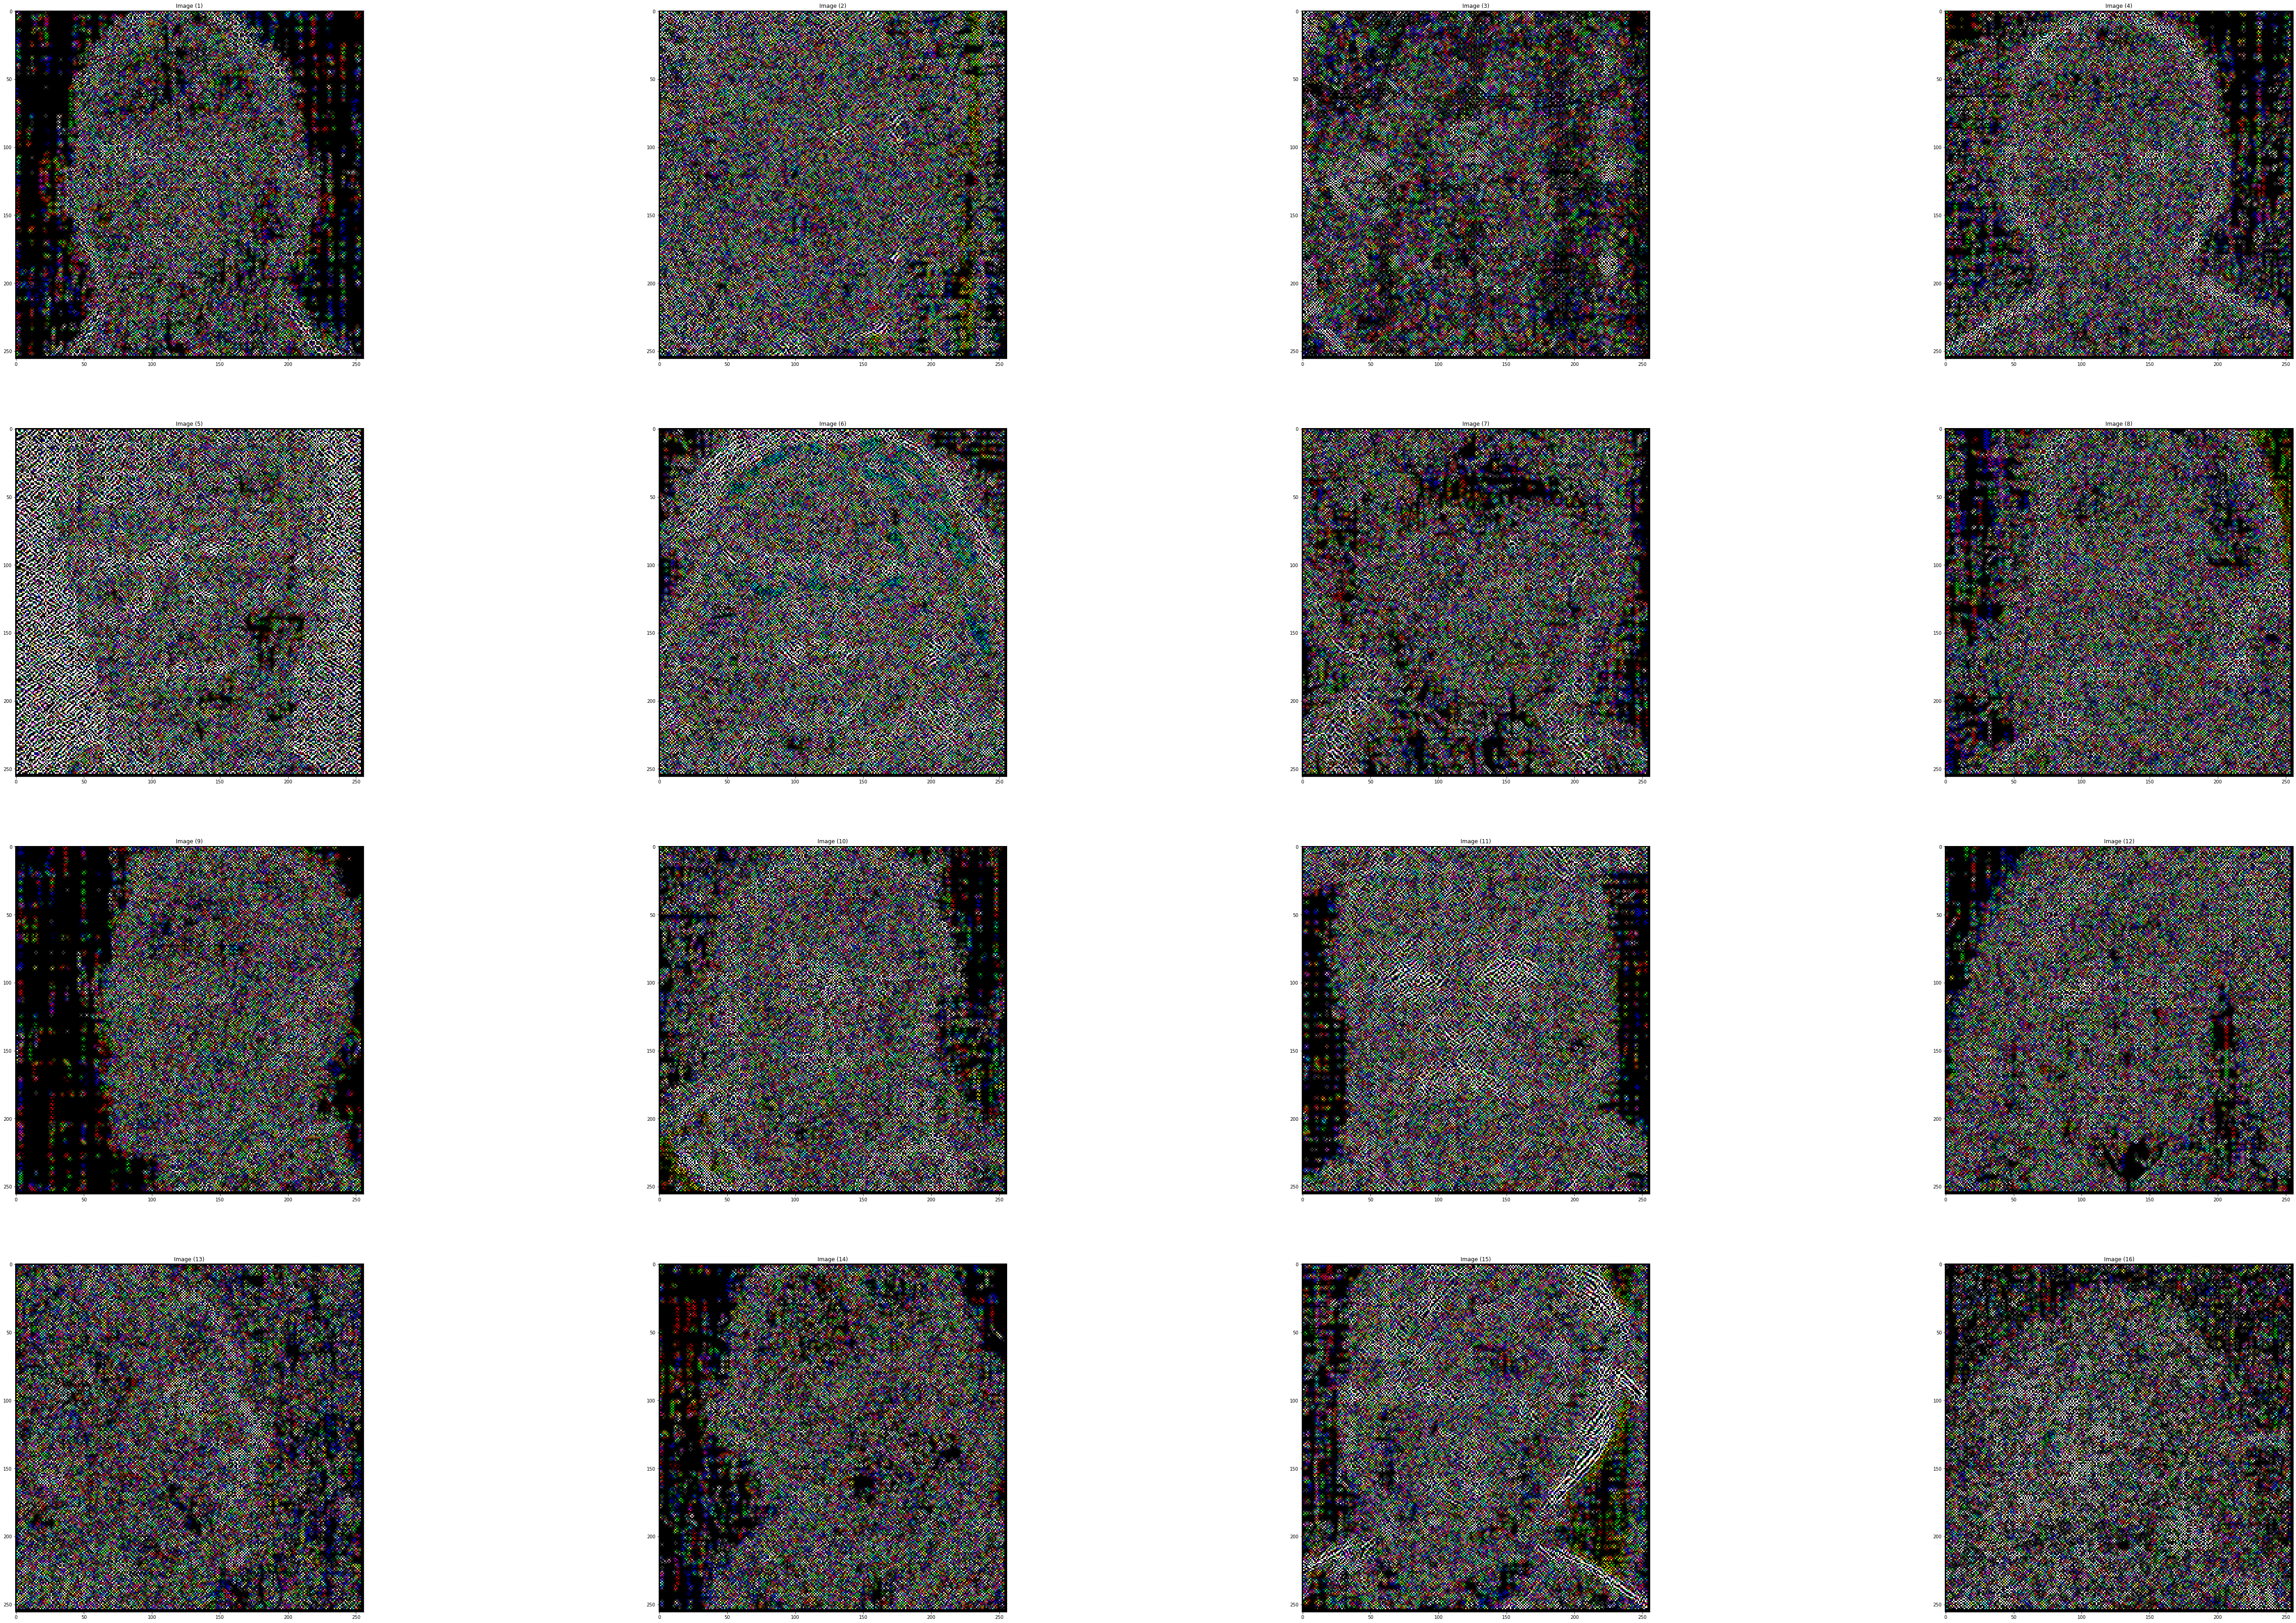

In [17]:
images = x.permute(0, 2, 3, 4, 1)[:, 0].cpu().numpy()
show_images(images, cols=len(images)//4)